in this notebook we make:

the correct/incorrect inconsistency maps.
providing the mean of uncertainty of incorrect and correct labels

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import numpy as np
import sys
import os
import glob
import imageio
import time
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from cv2 import medianBlur
import gdal
from osgeo import ogr
from osgeo import osr

sys.path.append("..")

from PIL import Image
from costum_arild.source.utils import image_processing_utils, gdal_utils, notebook_utils, model_utils
from costum_arild.source.data_processing import TrainingImage, divide_image, reassemble_big_image, reassemble_big_image_np

2022-04-20 00:00:28.513720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
def get_image_list_geo_projection(base_path_list, river_id, image_idx, prediction_type, river_names):
    all_image_paths = [sorted(glob.glob(os.path.join(base_path_list[exp_id], river_names[river_id], prediction_type, '*.tif'))) for exp_id in range(len(base_path_list))]
    image_paths = [all_image_paths[exp_id][image_idx] for exp_id in range(len(base_path_list))]
    # get the projection
    _, geo, project = image_processing_utils.read_tiff_file(large_image_path=image_paths[0], numpy_array_only=False)
    img_exp_arr_list = [image_processing_utils.read_tiff_file(large_image_path=image_path, numpy_array_only=True) for image_path in image_paths]
    img_arr = np.stack(img_exp_arr_list, axis=0)
    return img_arr, geo, project

def make_number_classes_save(numpy_array, geo, project, dest_path):
    os.makedirs(os.path.split(dest_path)[0], exist_ok=True)
    if numpy_array.ndim > 3:
        numpy_array = numpy_array.squeeze()
    numpy_array_diff=image_processing_utils.unique_values_axis(numpy_array)
    # write the array to file
    print(numpy_array_diff.shape)
    gdal_utils.write_array_to_raster(output_filepath=dest_path, array=numpy_array_diff, geo_transform=geo, projection=project)

def save_number_classes_river(base_path_list, dest_base_path, river_names, prediction_type):
    for river_id in range(len(river_names)):
        
        all_image_paths = [sorted(glob.glob(os.path.join(base_path_list[exp_id], river_names[river_id], prediction_type, '*.tif'))) for exp_id in range(len(base_path_list))]
        for image_id in range(len(all_image_paths[river_id])):
            print(all_image_paths[river_id][image_id])
            image_name = os.path.split(all_image_paths[river_id][image_id])[-1]
            print(f'working on image {image_name}')
            dest_path = os.path.join(dest_base_path, f'{river_names[river_id]}/{image_name}.tif')
            img_arr, geo, project = get_image_list_geo_projection(base_path_list=base_path_list, river_id=river_id, 
                                          image_idx=image_id, prediction_type=prediction_type, river_names=river_names)
            
            make_number_classes_save(numpy_array=img_arr, geo=geo, project=project, dest_path=dest_path)
            

def get_arr_using_id(arr_path, arr_id, file_type='tif'):
    """
    get the path to arr number arr_id at arr_path which has type of file_type
    """
    list_files = sorted(glob.glob(os.path.join(arr_path, f'*.{file_type}')))
    return list_files[arr_id]

In [4]:
def get_pred_lbl_mask_by_riverid(base_path_list, river_names, prediction_type, label_path_list, river_id):
    img_exp_list = []
    lbl_list = []
    mask_list = []
    list_images_rivers = [sorted( glob.glob (os.path.join(base_path_list[exp_id], river_names[river_id], prediction_type, '*.tif'))) 
                                      for exp_id in range(len(base_path_list))]

    for image_idx, _ in enumerate(list_images_rivers[river_id]):

        label_path = get_arr_using_id(arr_path=label_path_list[river_id], arr_id=image_idx, file_type='tif')
        label_arr = image_processing_utils.read_tiff_file(large_image_path=label_path, numpy_array_only=True)
        if unknown_zero:
            label_arr = image_processing_utils.swap_labels(arr=label_arr, lbl1=0, lbl2=5)

        img_arr, geo, project = get_image_list_geo_projection(base_path_list=base_path_list, 
                                                              river_id=river_id, 
                                                              image_idx=image_idx, 
                                                              prediction_type=prediction_type, 
                                                              river_names=river_names)

        label_base=os.path.split(label_path_list[river_id])[0]
        mask_shape_path = os.path.join(label_base, 'bounding_box.shp')
        mask = gdal_utils.load_shapefile_mask(shape_path=mask_shape_path, 
                                              img_arr=img_arr, 
                                              geo_transform=geo, 
                                              projection=project)
        img_list = []
        for exp_idx_tmp in range(img_arr.shape[0]):
            img_list.append(img_arr[exp_idx_tmp].flatten())
        # images: [ img1 which is 5 experiments
        #           img2 which is 5 experimets]
        img_exp_list.append(img_list)
        lbl_list.append(label_arr.flatten())
        mask_list.append(mask.flatten())
        
    return img_exp_list, lbl_list, mask_list

def predict_proba(X, model_function, num_samples):
    preds = [model_function(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)

def predict_proba_stacked(X, model_function, num_samples):
    preds = [softmax(model_function(X, training=True), axis=-1).squeeze() for _ in range(num_samples)]
    # the preidction will be [n_samples, x, y, n_class]
    return np.stack(preds, axis=0)

# Gaula image1

## Old model

In [5]:
# see if we can activate the dropout
# certainty of model
# load model
# we need to load the model and predict 
%autoreload
import seaborn as sns

from costum_arild.source.unet_vgg16_dropout import vgg16_unet_dropout

import tensorflow as tf
from costum_arild.source.utils.model_utils import enable_dropout_at_inference_for_model

have_lr_scheduler = True
model_no_dropout = model_utils.load_model('/home/saeid/phd/segmentation/experiments_results/New_dataset_experiments/exp_no13/unet_dropout/model.hdf5',
                                         have_lr_scheduler = have_lr_scheduler)
# load dropout model
model_dropout = vgg16_unet_dropout(freeze='0', dropout=0.1, num_classes=6)
model_dropout.set_weights(model_no_dropout.get_weights())

load model with Adam optimizer


2022-04-20 00:00:29.277738: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-20 00:00:29.278269: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-20 00:00:29.318101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 00:00:29.318546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Super with Max-Q Design computeCapability: 7.5
coreClock: 1.08GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2022-04-20 00:00:29.318602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-20 00:00:29.320053: I tensorflow/stre

In [6]:
# read image and get the output:
from scipy.special import softmax
from scipy.stats import entropy

no_dropout_samples = 20
add_filter_channel = False
river_name = 'gaula_1963_test'
image_name = '33-2-464-206-23.tif'
unknown_zero = True

dest_base = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/exp_no12/predictive entropy'
dest_path = os.path.join(dest_base, river_name)
os.makedirs(dest_path, exist_ok=True)

image_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'images')
label_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'labels')

# for big_image_path in glob.glob(os.path.join(image_path, "*.tif")):
    
big_image_path = os.path.join(image_path, image_name)
photoshop_corrected_label_base = f'/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/{river_name}/photoshop_corrected_label'
label_address = os.path.join(photoshop_corrected_label_base, image_name)
big_label_arr = image_processing_utils.read_png_file(label_address)

print(f'working on {big_image_path}')
images = divide_image(big_image_path, big_image_path, 
                          image_size=512, do_crop=False,
                          do_overlap=False)

unknown_class = 0
if unknown_zero:
    unknown_class = 5
    big_label_arr = image_processing_utils.swap_labels(arr=big_label_arr, lbl1=0, lbl2=5)

predictions = []
# Make predictions
for image in images:
    data = model_utils.convert_training_images_to_numpy_arrays([image],
                                                   add_filter_channel=add_filter_channel)[0]
    if not add_filter_channel and data.shape[-1] != 3:
        # print('add filter channel')
        data = model_utils.fake_colors(data)

    # prediction of no dropout
    prediction = model_no_dropout.predict(data)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction)
    predictions.append(prediction)

    # monto_carlo of the dropout
    monto_carlo_dropout = predict_proba_stacked(X=data, 
                                                model_function=model_dropout, 
                                                num_samples=no_dropout_samples)
    uncertainty = entropy(monto_carlo_dropout.mean(axis=0), axis=-1)

    # save certainty
    image.labels = uncertainty


big_image_ds = gdal.Open(big_image_path)
geo_transform = big_image_ds.GetGeoTransform()
projection = big_image_ds.GetProjection()
big_image_shape = (big_image_ds.RasterYSize, big_image_ds.RasterXSize)
big_image_ds = None  # Close the image the gdal way

big_entropy_array = reassemble_big_image(images, small_image_size=512,
                                           big_image_shape=big_image_shape)
# changing the black background to have better visualization
big_entropy_array[big_entropy_array == 0] = big_entropy_array[big_entropy_array > 0].min()


big_prediction_array = reassemble_big_image_np(images, filling_array=predictions, small_image_size=512,
                                           big_image_shape=big_image_shape)


#     gdal_utils.write_array_to_raster_float(output_filepath= os.path.join(dest_path, big_image_name),
#                                      array=big_image_array, 
#                                      geo_transform=geo_transform, 
#                                      projection=projection)
# break
print(f'avg entropy: {big_entropy_array.mean()}')

working on /home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/gaula_1963_test/images/33-2-464-206-23.tif


2022-04-20 00:00:32.018918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-20 00:00:32.037206: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz
2022-04-20 00:00:32.230826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-20 00:00:32.794832: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-04-20 00:00:32.826254: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-20 00:00:33.233511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


avg entropy: 1.7055677687099426


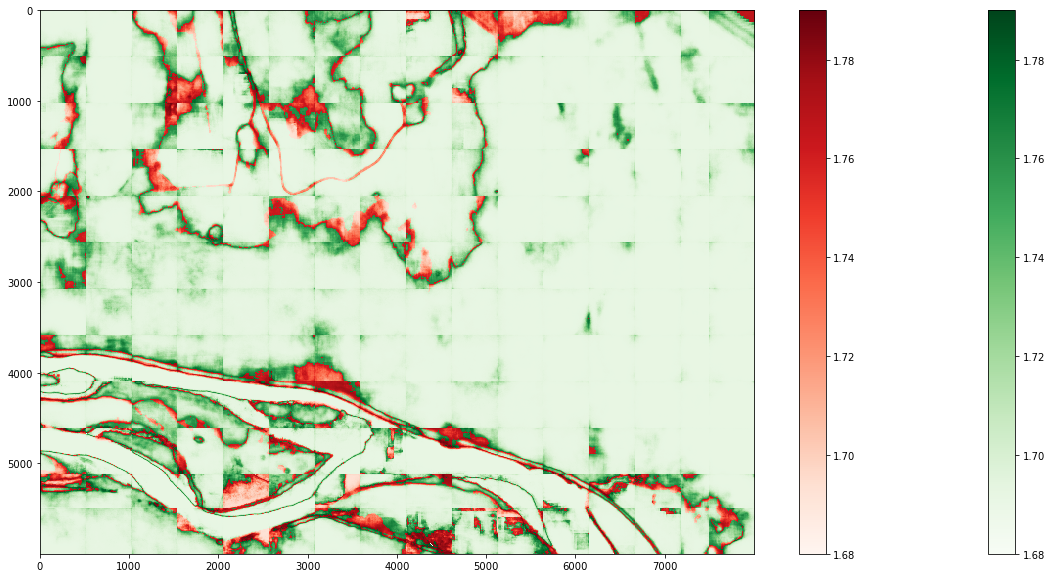

In [7]:
correct_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array != big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
incorrect_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array == big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
# plot the image

# show confidence, where label is correct
fig, ax = plt.subplots(figsize=(20, 10))

correct = plt.imshow(correct_matrix, 
                        cmap='Greens', vmin=1.68, vmax=1.79, 
                        interpolation='nearest', aspect='auto')
incorrect = plt.imshow(incorrect_matrix, 
                           cmap='Reds', vmin=1.68, vmax=1.79, 
                           interpolation='nearest', aspect='auto')

correct_bar = plt.colorbar(correct)
incorrect_bar = plt.colorbar(incorrect)

plt.show()
# save the image
save_plot_path = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots'
fig.savefig(os.path.join(save_plot_path, image_name.replace('.tif','old.png')), dpi=500) 

In [8]:
correct_matrix.mean(), incorrect_matrix.mean()

(1.702065218768822, 1.7460364310401795)

## New Model

In [9]:
# see if we can activate the dropout
# certainty of model
# load model
# we need to load the model and predict 
%autoreload
import seaborn as sns

from costum_arild.source.unet_vgg16_dropout import vgg16_unet_dropout

import tensorflow as tf
from costum_arild.source.utils.model_utils import enable_dropout_at_inference_for_model

have_lr_scheduler = True
model_no_dropout = model_utils.load_model('/home/saeid/phd/segmentation/experiments_results/New_dataset_experiments/exp_no12/2022-02-03_18:03:57.704819_vgg16_freeze_0/model_swa.hdf5',
                                         have_lr_scheduler = have_lr_scheduler)
# load dropout model
model_dropout = vgg16_unet_dropout(freeze='0', dropout=0.1, num_classes=6)
model_dropout.set_weights(model_no_dropout.get_weights())

load model with Adam optimizer


In [10]:
# read image and get the output:
from scipy.special import softmax
from scipy.stats import entropy

no_dropout_samples = 20
add_filter_channel = False
river_name = 'gaula_1963_test'
image_name = '33-2-464-206-23.tif'
unknown_zero = False

dest_base = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/exp_no12/predictive entropy'
dest_path = os.path.join(dest_base, river_name)
os.makedirs(dest_path, exist_ok=True)

image_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'images')
label_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'labels')

# for big_image_path in glob.glob(os.path.join(image_path, "*.tif")):
    
big_image_path = os.path.join(image_path, image_name)
photoshop_corrected_label_base = f'/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/{river_name}/photoshop_corrected_label'
label_address = os.path.join(photoshop_corrected_label_base, image_name)
big_label_arr = image_processing_utils.read_png_file(label_address)

print(f'working on {big_image_path}')
images = divide_image(big_image_path, big_image_path, 
                          image_size=512, do_crop=False,
                          do_overlap=False)

unknown_class = 0
if unknown_zero:
    unknown_class = 5
    big_label_arr = image_processing_utils.swap_labels(arr=big_label_arr, lbl1=0, lbl2=5)

predictions = []
# Make predictions
for image in images:
    data = model_utils.convert_training_images_to_numpy_arrays([image],
                                                   add_filter_channel=add_filter_channel)[0]
    if not add_filter_channel and data.shape[-1] != 3:
        # print('add filter channel')
        data = model_utils.fake_colors(data)

    # prediction of no dropout
    prediction = model_no_dropout.predict(data)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction)
    predictions.append(prediction)

    # monto_carlo of the dropout
    monto_carlo_dropout = predict_proba_stacked(X=data, 
                                                model_function=model_dropout, 
                                                num_samples=no_dropout_samples)
    uncertainty = entropy(monto_carlo_dropout.mean(axis=0), axis=-1)

    # save certainty
    image.labels = uncertainty


big_image_ds = gdal.Open(big_image_path)
geo_transform = big_image_ds.GetGeoTransform()
projection = big_image_ds.GetProjection()
big_image_shape = (big_image_ds.RasterYSize, big_image_ds.RasterXSize)
big_image_ds = None  # Close the image the gdal way

big_entropy_array = reassemble_big_image(images, small_image_size=512,
                                           big_image_shape=big_image_shape)
# changing the black background to have better visualization
big_entropy_array[big_entropy_array == 0] = big_entropy_array[big_entropy_array > 0].min()


big_prediction_array = reassemble_big_image_np(images, filling_array=predictions, small_image_size=512,
                                           big_image_shape=big_image_shape)


#     gdal_utils.write_array_to_raster_float(output_filepath= os.path.join(dest_path, big_image_name),
#                                      array=big_image_array, 
#                                      geo_transform=geo_transform, 
#                                      projection=projection)
# break
print(f'avg entropy: {big_entropy_array.mean()}')

working on /home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/gaula_1963_test/images/33-2-464-206-23.tif
avg entropy: 1.6993590693675529


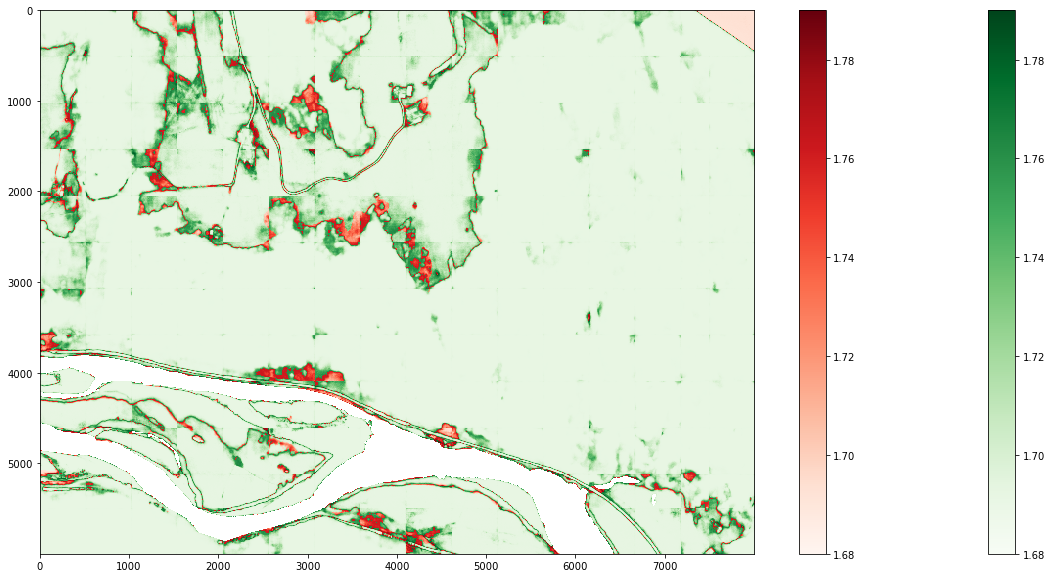

In [11]:
correct_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array != big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
incorrect_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array == big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
# plot the image

# show confidence, where label is correct
fig, ax = plt.subplots(figsize=(20, 10))

correct = plt.imshow(correct_matrix, 
                        cmap='Greens', vmin=1.68, vmax=1.79, 
                        interpolation='nearest', aspect='auto')
incorrect = plt.imshow(incorrect_matrix, 
                           cmap='Reds', vmin=1.68, vmax=1.79, 
                           interpolation='nearest', aspect='auto')

correct_bar = plt.colorbar(correct)
incorrect_bar = plt.colorbar(incorrect)

plt.show()
# save the image
save_plot_path = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots'
fig.savefig(os.path.join(save_plot_path, image_name.replace('.tif','new.png')), dpi=500) 

In [12]:
correct_matrix.mean(), incorrect_matrix.mean()

(1.6977727892209027, 1.7436827075950188)

# Nea image1

## Old model

In [13]:
# see if we can activate the dropout
# certainty of model
# load model
# we need to load the model and predict 
%autoreload
import seaborn as sns

from costum_arild.source.unet_vgg16_dropout import vgg16_unet_dropout

import tensorflow as tf
from costum_arild.source.utils.model_utils import enable_dropout_at_inference_for_model

have_lr_scheduler = True
model_no_dropout = model_utils.load_model('/home/saeid/phd/segmentation/experiments_results/New_dataset_experiments/exp_no13/unet_dropout/model.hdf5',
                                         have_lr_scheduler = have_lr_scheduler)
# load dropout model
model_dropout = vgg16_unet_dropout(freeze='0', dropout=0.1, num_classes=6)
model_dropout.set_weights(model_no_dropout.get_weights())

load model with Adam optimizer


In [14]:
# read image and get the output:
from scipy.special import softmax
from scipy.stats import entropy

no_dropout_samples = 20
add_filter_channel = False
river_name = 'nea_1962_test'
image_name = '33-2-469-211-20.tif'
unknown_zero = True

dest_base = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/exp_no12/predictive entropy'
dest_path = os.path.join(dest_base, river_name)
os.makedirs(dest_path, exist_ok=True)

image_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'images')
label_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'labels')

# for big_image_path in glob.glob(os.path.join(image_path, "*.tif")):
    
big_image_path = os.path.join(image_path, image_name)
photoshop_corrected_label_base = f'/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/{river_name}/photoshop_corrected_label'
label_address = os.path.join(photoshop_corrected_label_base, image_name)
big_label_arr = image_processing_utils.read_png_file(label_address)

print(f'working on {big_image_path}')
images = divide_image(big_image_path, big_image_path, 
                          image_size=512, do_crop=False,
                          do_overlap=False)

unknown_class = 0
if unknown_zero:
    unknown_class = 5
    big_label_arr = image_processing_utils.swap_labels(arr=big_label_arr, lbl1=0, lbl2=5)
    

predictions = []
# Make predictions
for image in images:
    data = model_utils.convert_training_images_to_numpy_arrays([image],
                                                   add_filter_channel=add_filter_channel)[0]
    if not add_filter_channel and data.shape[-1] != 3:
        # print('add filter channel')
        data = model_utils.fake_colors(data)

    # prediction of no dropout
    prediction = model_no_dropout.predict(data)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction)
    predictions.append(prediction)

    # monto_carlo of the dropout
    monto_carlo_dropout = predict_proba_stacked(X=data, 
                                                model_function=model_dropout, 
                                                num_samples=no_dropout_samples)
    uncertainty = entropy(monto_carlo_dropout.mean(axis=0), axis=-1)

    # save certainty
    image.labels = uncertainty


big_image_ds = gdal.Open(big_image_path)
geo_transform = big_image_ds.GetGeoTransform()
projection = big_image_ds.GetProjection()
big_image_shape = (big_image_ds.RasterYSize, big_image_ds.RasterXSize)
big_image_ds = None  # Close the image the gdal way

big_entropy_array = reassemble_big_image(images, small_image_size=512,
                                           big_image_shape=big_image_shape)
# changing the black background to have better visualization
big_entropy_array[big_entropy_array == 0] = big_entropy_array[big_entropy_array > 0].min()


big_prediction_array = reassemble_big_image_np(images, filling_array=predictions, small_image_size=512,
                                           big_image_shape=big_image_shape)


#     gdal_utils.write_array_to_raster_float(output_filepath= os.path.join(dest_path, big_image_name),
#                                      array=big_image_array, 
#                                      geo_transform=geo_transform, 
#                                      projection=projection)
# break
print(f'avg entropy: {big_entropy_array.mean()}')

working on /home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/nea_1962_test/images/33-2-469-211-20.tif
avg entropy: 1.708680015189581


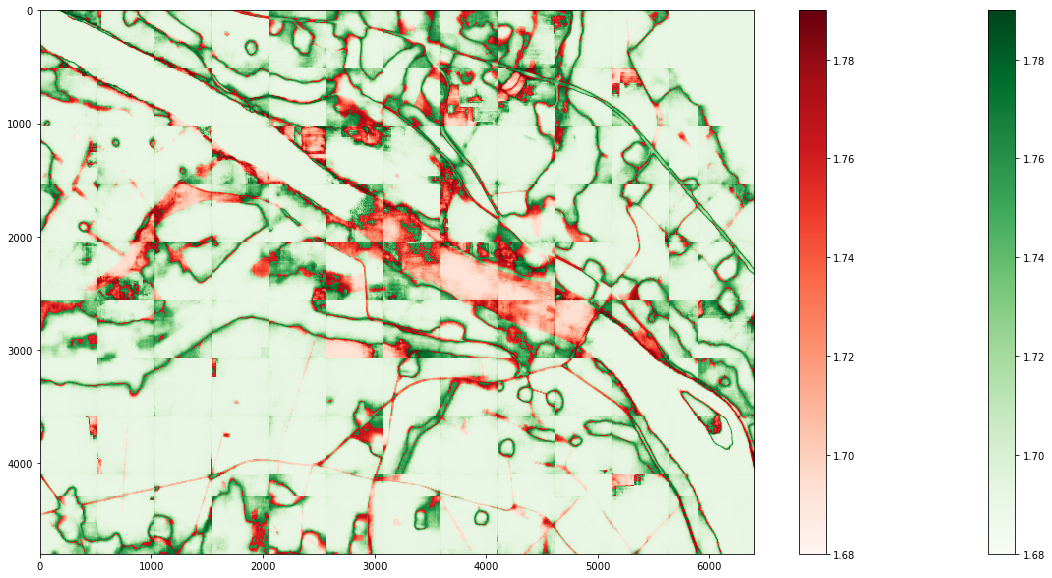

In [15]:
correct_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array != big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
incorrect_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array == big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
# plot the image

# show confidence, where label is correct
fig, ax = plt.subplots(figsize=(20, 10))

correct = plt.imshow(correct_matrix, 
                        cmap='Greens', vmin=1.68, vmax=1.79, 
                        interpolation='nearest', aspect='auto')
incorrect = plt.imshow(incorrect_matrix, 
                           cmap='Reds', vmin=1.68, vmax=1.79, 
                           interpolation='nearest', aspect='auto')

correct_bar = plt.colorbar(correct)
incorrect_bar = plt.colorbar(incorrect)

plt.show()
# save the image
save_plot_path = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots'
fig.savefig(os.path.join(save_plot_path, image_name.replace('.tif','old.png')), dpi=500)  

In [16]:
correct_matrix.mean(), incorrect_matrix.mean()

(1.704525230483474, 1.7363515944831625)

## New Model

In [17]:
# see if we can activate the dropout
# certainty of model
# load model
# we need to load the model and predict 
%autoreload
import seaborn as sns

from costum_arild.source.unet_vgg16_dropout import vgg16_unet_dropout

import tensorflow as tf
from costum_arild.source.utils.model_utils import enable_dropout_at_inference_for_model

have_lr_scheduler = True
model_no_dropout = model_utils.load_model('/home/saeid/phd/segmentation/experiments_results/New_dataset_experiments/exp_no12/2022-02-03_18:03:57.704819_vgg16_freeze_0/model_swa.hdf5',
                                         have_lr_scheduler = have_lr_scheduler)
# load dropout model
model_dropout = vgg16_unet_dropout(freeze='0', dropout=0.1, num_classes=6)
model_dropout.set_weights(model_no_dropout.get_weights())

load model with Adam optimizer


In [18]:
# read image and get the output:
from scipy.special import softmax
from scipy.stats import entropy

no_dropout_samples = 20
add_filter_channel = False
river_name = 'nea_1962_test'
image_name = '33-2-469-211-20.tif'
unknown_zero = False

dest_base = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/exp_no12/predictive entropy'
dest_path = os.path.join(dest_base, river_name)
os.makedirs(dest_path, exist_ok=True)

image_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'images')
label_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'labels')

# for big_image_path in glob.glob(os.path.join(image_path, "*.tif")):
    
big_image_path = os.path.join(image_path, image_name)
photoshop_corrected_label_base = f'/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/{river_name}/photoshop_corrected_label'
label_address = os.path.join(photoshop_corrected_label_base, image_name)
big_label_arr = image_processing_utils.read_png_file(label_address)

print(f'working on {big_image_path}')
images = divide_image(big_image_path, big_image_path, 
                          image_size=512, do_crop=False,
                          do_overlap=False)

unknown_class = 0
if unknown_zero:
    unknown_class = 5
    big_label_arr = image_processing_utils.swap_labels(arr=big_label_arr, lbl1=0, lbl2=5)


predictions = []
# Make predictions
for image in images:
    data = model_utils.convert_training_images_to_numpy_arrays([image],
                                                   add_filter_channel=add_filter_channel)[0]
    if not add_filter_channel and data.shape[-1] != 3:
        # print('add filter channel')
        data = model_utils.fake_colors(data)

    # prediction of no dropout
    prediction = model_no_dropout.predict(data)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction)
    predictions.append(prediction)

    # monto_carlo of the dropout
    monto_carlo_dropout = predict_proba_stacked(X=data, 
                                                model_function=model_dropout, 
                                                num_samples=no_dropout_samples)
    uncertainty = entropy(monto_carlo_dropout.mean(axis=0), axis=-1)

    # save certainty
    image.labels = uncertainty


big_image_ds = gdal.Open(big_image_path)
geo_transform = big_image_ds.GetGeoTransform()
projection = big_image_ds.GetProjection()
big_image_shape = (big_image_ds.RasterYSize, big_image_ds.RasterXSize)
big_image_ds = None  # Close the image the gdal way

big_entropy_array = reassemble_big_image(images, small_image_size=512,
                                           big_image_shape=big_image_shape)
# changing the black background to have better visualization
big_entropy_array[big_entropy_array == 0] = big_entropy_array[big_entropy_array > 0].min()


big_prediction_array = reassemble_big_image_np(images, filling_array=predictions, small_image_size=512,
                                           big_image_shape=big_image_shape)


#     gdal_utils.write_array_to_raster_float(output_filepath= os.path.join(dest_path, big_image_name),
#                                      array=big_image_array, 
#                                      geo_transform=geo_transform, 
#                                      projection=projection)
# break
print(f'avg entropy: {big_entropy_array.mean()}')

working on /home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/nea_1962_test/images/33-2-469-211-20.tif
avg entropy: 1.709589805653435


In [19]:
big_entropy_array.mean()

1.709589805653435

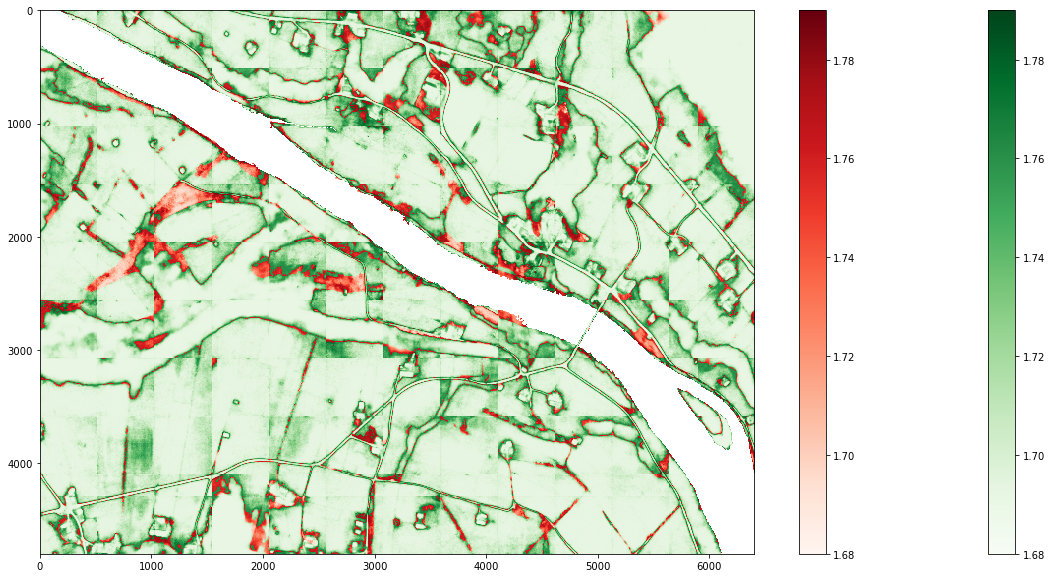

In [20]:
correct_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array != big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
incorrect_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array == big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
# plot the image

# show confidence, where label is correct
fig, ax = plt.subplots(figsize=(20, 10))

correct = plt.imshow(correct_matrix, 
                        cmap='Greens', vmin=1.68, vmax=1.79, 
                        interpolation='nearest', aspect='auto')
incorrect = plt.imshow(incorrect_matrix, 
                           cmap='Reds', vmin=1.68, vmax=1.79, 
                           interpolation='nearest', aspect='auto')

correct_bar = plt.colorbar(correct)
incorrect_bar = plt.colorbar(incorrect)

plt.show()

# save figures
save_plot_path = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots'
fig.savefig(os.path.join(save_plot_path, image_name.replace('.tif','new.png')), dpi=500)

In [21]:
correct_matrix.mean(), incorrect_matrix.mean()

(1.7071310649305345, 1.7501611458999407)

# Gaula 1998

## Old model

In [22]:
# see if we can activate the dropout
# certainty of model
# load model
# we need to load the model and predict 
%autoreload
import seaborn as sns

from costum_arild.source.unet_vgg16_dropout import vgg16_unet_dropout

import tensorflow as tf
from costum_arild.source.utils.model_utils import enable_dropout_at_inference_for_model

have_lr_scheduler = True
model_no_dropout = model_utils.load_model('/home/saeid/phd/segmentation/experiments_results/New_dataset_experiments/exp_no13/unet_dropout/model.hdf5',
                                         have_lr_scheduler = have_lr_scheduler)
# load dropout model
model_dropout = vgg16_unet_dropout(freeze='0', dropout=0.1, num_classes=6)
model_dropout.set_weights(model_no_dropout.get_weights())

load model with Adam optimizer


In [23]:
# read image and get the output:
from scipy.special import softmax
from scipy.stats import entropy

no_dropout_samples = 20
add_filter_channel = False
river_name = 'gaula_1998_test'
image_name = '33-2-462-213-32.tif'
unknown_zero = True

dest_base = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/exp_no12/predictive entropy'
dest_path = os.path.join(dest_base, river_name)
os.makedirs(dest_path, exist_ok=True)

image_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'images')
label_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'labels')

# for big_image_path in glob.glob(os.path.join(image_path, "*.tif")):
    
big_image_path = os.path.join(image_path, image_name)
photoshop_corrected_label_base = f'/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/{river_name}/photoshop_corrected_label'
label_address = os.path.join(photoshop_corrected_label_base, image_name)
big_label_arr = image_processing_utils.read_png_file(label_address)

print(f'working on {big_image_path}')
images = divide_image(big_image_path, big_image_path, 
                          image_size=512, do_crop=False,
                          do_overlap=False)


unknown_class = 0
if unknown_zero:
    unknown_class = 5
    big_label_arr = image_processing_utils.swap_labels(arr=big_label_arr, lbl1=0, lbl2=5)


predictions = []
# Make predictions
for image in images:
    data = model_utils.convert_training_images_to_numpy_arrays([image],
                                                   add_filter_channel=add_filter_channel)[0]
    if not add_filter_channel and data.shape[-1] != 3:
        # print('add filter channel')
        data = model_utils.fake_colors(data)

    # prediction of no dropout
    prediction = model_no_dropout.predict(data)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction)
    predictions.append(prediction)

    # monto_carlo of the dropout
    monto_carlo_dropout = predict_proba_stacked(X=data, 
                                                model_function=model_dropout, 
                                                num_samples=no_dropout_samples)
    uncertainty = entropy(monto_carlo_dropout.mean(axis=0), axis=-1)

    # save certainty
    image.labels = uncertainty


big_image_ds = gdal.Open(big_image_path)
geo_transform = big_image_ds.GetGeoTransform()
projection = big_image_ds.GetProjection()
big_image_shape = (big_image_ds.RasterYSize, big_image_ds.RasterXSize)
big_image_ds = None  # Close the image the gdal way

big_entropy_array = reassemble_big_image(images, small_image_size=512,
                                           big_image_shape=big_image_shape)
# changing the black background to have better visualization
big_entropy_array[big_entropy_array == 0] = big_entropy_array[big_entropy_array > 0].min()


big_prediction_array = reassemble_big_image_np(images, filling_array=predictions, small_image_size=512,
                                           big_image_shape=big_image_shape)


#     gdal_utils.write_array_to_raster_float(output_filepath= os.path.join(dest_path, big_image_name),
#                                      array=big_image_array, 
#                                      geo_transform=geo_transform, 
#                                      projection=projection)
# break
print(f'avg entropy: {big_entropy_array.mean()}')

working on /home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/gaula_1998_test/images/33-2-462-213-32.tif
avg entropy: 1.7104846432804912


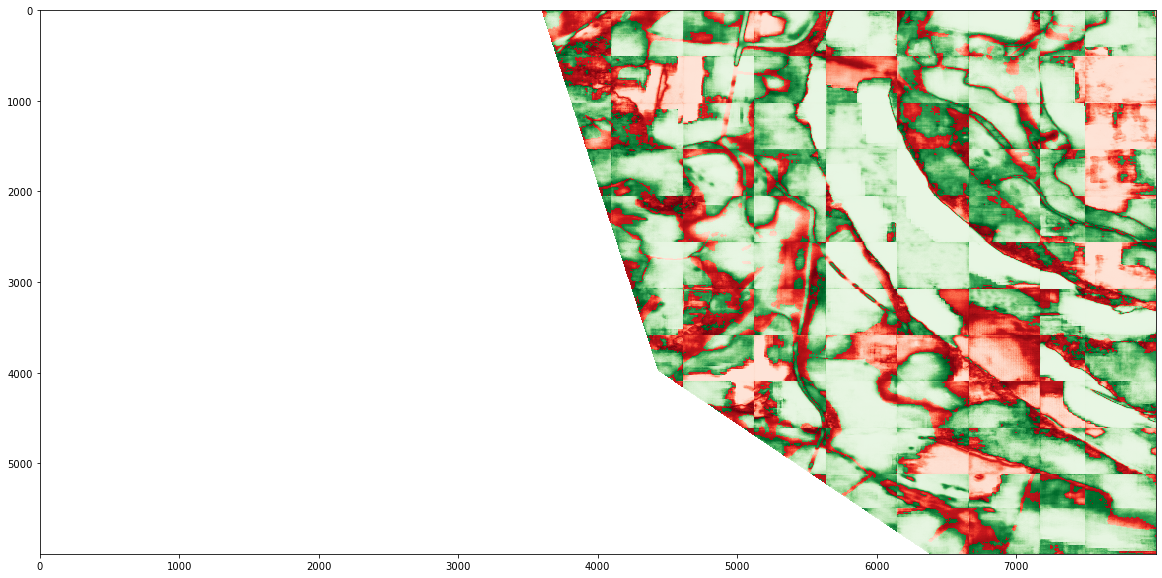

In [24]:
correct_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array != big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
incorrect_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array == big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
# plot the image

# show confidence, where label is correct
fig, ax = plt.subplots(figsize=(20, 10))

correct = plt.imshow(correct_matrix, 
                        cmap='Greens', vmin=1.68, vmax=1.79, 
                        interpolation='nearest', aspect='auto')
incorrect = plt.imshow(incorrect_matrix, 
                           cmap='Reds', vmin=1.68, vmax=1.79, 
                           interpolation='nearest', aspect='auto')

correct_bar = plt.colorbar(correct)
incorrect_bar = plt.colorbar(incorrect)


plt.show()
# save the image
save_plot_path = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots'
fig.savefig(os.path.join(save_plot_path, image_name.replace('.tif','old.png')), dpi=500)  

In [25]:
correct_matrix.mean(), incorrect_matrix.mean()

(1.7204718982070994, 1.7404926589794587)

## New Model

In [26]:
# see if we can activate the dropout
# certainty of model
# load model
# we need to load the model and predict 
%autoreload
import seaborn as sns

from costum_arild.source.unet_vgg16_dropout import vgg16_unet_dropout

import tensorflow as tf
from costum_arild.source.utils.model_utils import enable_dropout_at_inference_for_model

have_lr_scheduler = True
model_no_dropout = model_utils.load_model('/home/saeid/phd/segmentation/experiments_results/New_dataset_experiments/exp_no12/2022-02-03_18:03:57.704819_vgg16_freeze_0/model_swa.hdf5',
                                         have_lr_scheduler = have_lr_scheduler)
# load dropout model
model_dropout = vgg16_unet_dropout(freeze='0', dropout=0.1, num_classes=6)
model_dropout.set_weights(model_no_dropout.get_weights())

load model with Adam optimizer


In [27]:
# read image and get the output:
from scipy.special import softmax
from scipy.stats import entropy

no_dropout_samples = 20
add_filter_channel = False
river_name = 'gaula_1998_test'
image_name = '33-2-462-213-32.tif'
unknown_zero = False

dest_base = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/exp_no12/predictive entropy'
dest_path = os.path.join(dest_base, river_name)
os.makedirs(dest_path, exist_ok=True)

image_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'images')
label_path = os.path.join('/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images', river_name, 'labels')

# for big_image_path in glob.glob(os.path.join(image_path, "*.tif")):
    
big_image_path = os.path.join(image_path, image_name)
photoshop_corrected_label_base = f'/home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/{river_name}/photoshop_corrected_label'
label_address = os.path.join(photoshop_corrected_label_base, image_name)
big_label_arr = image_processing_utils.read_png_file(label_address)

print(f'working on {big_image_path}')
images = divide_image(big_image_path, big_image_path, 
                          image_size=512, do_crop=False,
                          do_overlap=False)

unknown_class = 0
if unknown_zero:
    unknown_class = 5
    big_label_arr = image_processing_utils.swap_labels(arr=big_label_arr, lbl1=0, lbl2=5)


predictions = []
# Make predictions
for image in images:
    data = model_utils.convert_training_images_to_numpy_arrays([image],
                                                   add_filter_channel=add_filter_channel)[0]
    if not add_filter_channel and data.shape[-1] != 3:
        # print('add filter channel')
        data = model_utils.fake_colors(data)

    # prediction of no dropout
    prediction = model_no_dropout.predict(data)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction)
    predictions.append(prediction)

    # monto_carlo of the dropout
    monto_carlo_dropout = predict_proba_stacked(X=data, 
                                                model_function=model_dropout, 
                                                num_samples=no_dropout_samples)
    uncertainty = entropy(monto_carlo_dropout.mean(axis=0), axis=-1)

    # save certainty
    image.labels = uncertainty


big_image_ds = gdal.Open(big_image_path)
geo_transform = big_image_ds.GetGeoTransform()
projection = big_image_ds.GetProjection()
big_image_shape = (big_image_ds.RasterYSize, big_image_ds.RasterXSize)
big_image_ds = None  # Close the image the gdal way

big_entropy_array = reassemble_big_image(images, small_image_size=512,
                                           big_image_shape=big_image_shape)
# changing the black background to have better visualization
big_entropy_array[big_entropy_array == 0] = big_entropy_array[big_entropy_array > 0].min()


big_prediction_array = reassemble_big_image_np(images, filling_array=predictions, small_image_size=512,
                                           big_image_shape=big_image_shape)


#     gdal_utils.write_array_to_raster_float(output_filepath= os.path.join(dest_path, big_image_name),
#                                      array=big_image_array, 
#                                      geo_transform=geo_transform, 
#                                      projection=projection)
# break
print(f'avg entropy: {big_entropy_array.mean()}')

working on /home/saeid/phd/segmentation/dataset/test_dataset/bounding_box_images/gaula_1998_test/images/33-2-462-213-32.tif
avg entropy: 1.698423369729715


In [28]:
big_entropy_array.mean()

1.698423369729715

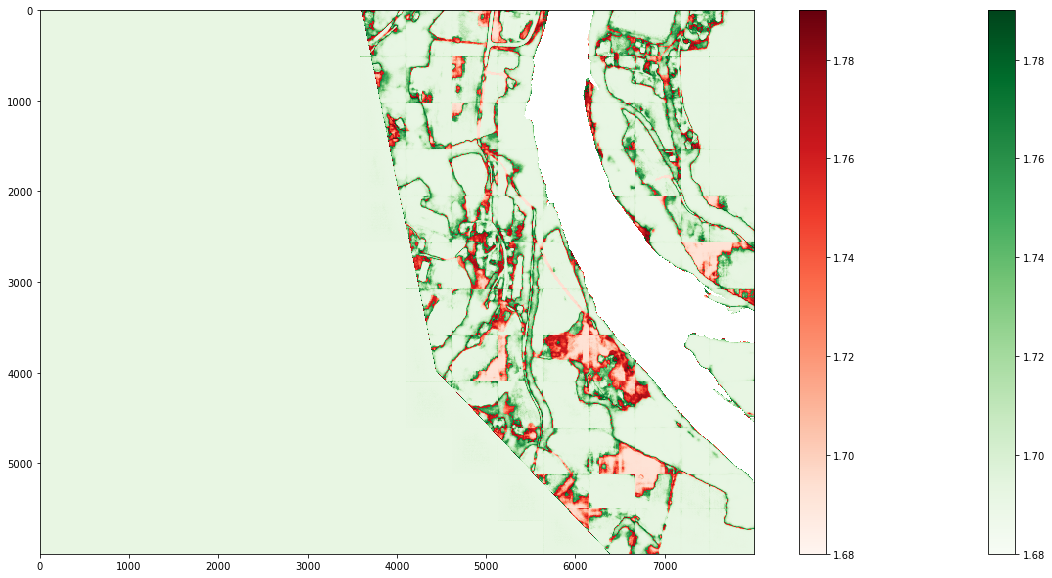

In [29]:
# plot the image

# show confidence, where label is correct
correct_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array != big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
incorrect_matrix = np.ma.masked_array(big_entropy_array, (big_prediction_array == big_label_arr.squeeze()) | (big_label_arr.squeeze() == unknown_class))
# plot the image

# show confidence, where label is correct
fig, ax = plt.subplots(figsize=(20, 10))

correct = plt.imshow(correct_matrix, 
                        cmap='Greens', vmin=1.68, vmax=1.79, 
                        interpolation='nearest', aspect='auto')
incorrect = plt.imshow(incorrect_matrix, 
                           cmap='Reds', vmin=1.68, vmax=1.79, 
                           interpolation='nearest', aspect='auto')

correct_bar = plt.colorbar(correct)
incorrect_bar = plt.colorbar(incorrect)


# correct_bar.set_label('Correct prediction predictive uncertainty')
# incorrect_bar.set_label('Incorrect prediction predictive uncertainty')

plt.show()

# save figures
save_plot_path = '/home/saeid/phd/segmentation/experiments_testset_predictions/New_dataset_experiments/plots'
fig.savefig(os.path.join(save_plot_path, image_name.replace('.tif','new.png')), dpi=500)

In [30]:
correct_matrix.mean(), incorrect_matrix.mean()

(1.6960201489346076, 1.736010540651973)